# ML Data set


# Load the packages

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

# gradient boosting for regression in scikit-learn
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from sklearn.datasets import make_classification
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier

/Users/eunbinkim/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Load the cluster data 

In [2]:
#read the cluster data in parquet
odf = pd.read_parquet('clusterdata.parquet.snappy')

In [3]:
odf

,x,y,R_proj,v_los,flag,proj_axis,cluster_id,gal_id
0,1.435010,-4.354630,4.58499,-1727.400,0,xy,0001,0
1,1.076120,-4.057220,4.19751,-1850.020,0,xy,0001,1
2,-4.315750,2.407100,4.94164,-2867.620,0,xy,0001,2
3,0.717368,-4.490940,4.54788,-1746.100,0,xy,0001,3
4,0.198263,-4.517540,4.52189,-1658.320,0,xy,0001,4
...,...,...,...,...,...,...,...,...
3207155,-2.366860,0.946819,2.54922,233.506,0,yz,2621,408
3207156,-2.756740,1.714310,3.24630,891.324,0,yz,2621,409
3207157,-4.548310,-1.665560,4.84368,217.310,3,yz,2621,410
3207158,-2.094290,1.472960,2.56040,1645.640,0,yz,2621,411


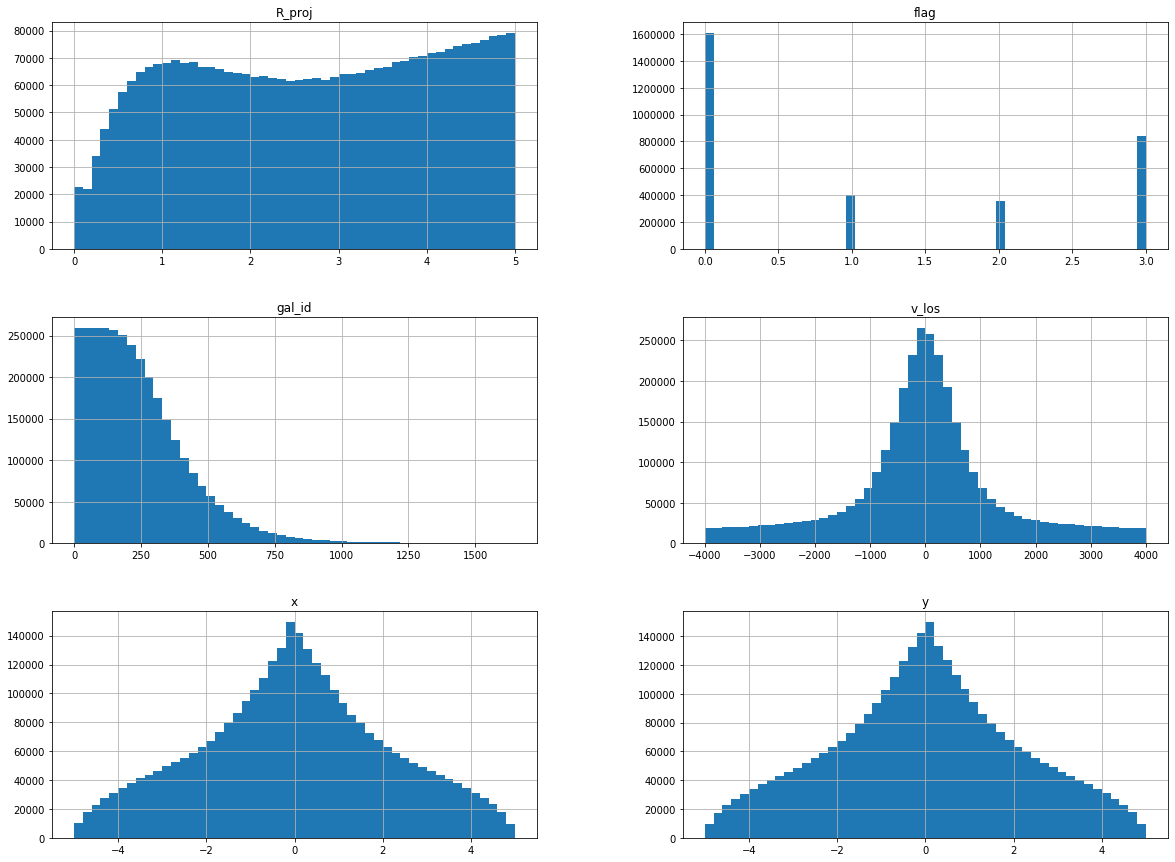

In [4]:
%matplotlib inline

odf.hist(bins=50,figsize=(20,15))
plt.show()

# Data set: selecting largest cluster 

In [43]:
#Check the largest cluster
odf.groupby('cluster_id').count().sort_values('gal_id').tail(3)

,x,y,R_proj,v_los,flag,proj_axis,gal_id,cluster_id_num,label
cluster_id,,,,,,,,,
0062,3453,3453,3453,3453,3453,3453,3453,3453,3453
2151,3633,3633,3633,3633,3633,3633,3633,3633,3633
1562,4442,4442,4442,4442,4442,4442,4442,4442,4442


In [6]:
grouped = odf.groupby('cluster_id')

In [7]:
len(grouped.groups.keys())

2621

In [8]:
len(odf['cluster_id'].unique())

2621

In [9]:
odf['cluster_id']

0          0001
1          0001
2          0001
3          0001
4          0001
           ... 
3207155    2621
3207156    2621
3207157    2621
3207158    2621
3207159    2621
Name: cluster_id, Length: 3207160, dtype: object

In [10]:
odf.columns

Index(['x', 'y', 'R_proj', 'v_los', 'flag', 'proj_axis', 'cluster_id',
       'gal_id'],
      dtype='object')

In [11]:
odf.dtypes

x             float64
y             float64
R_proj        float64
v_los         float64
flag            int64
proj_axis      object
cluster_id     object
gal_id          int64
dtype: object

In [12]:
#Add new column for type changed data
odf['cluster_id_num'] = odf['cluster_id'].apply(lambda x: np.int(x))

In [13]:
odf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3207160 entries, 0 to 3207159
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   x               float64
 1   y               float64
 2   R_proj          float64
 3   v_los           float64
 4   flag            int64  
 5   proj_axis       object 
 6   cluster_id      object 
 7   gal_id          int64  
 8   cluster_id_num  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 220.2+ MB


In [14]:
odf.dtypes

x                 float64
y                 float64
R_proj            float64
v_los             float64
flag                int64
proj_axis          object
cluster_id         object
gal_id              int64
cluster_id_num      int64
dtype: object

In [16]:
# Change the flag = 1,2,3 to flag = 1
# add new column for saving changed flag
odf['label'] = odf['flag'].apply(lambda x: '1' if x>0 else x)

In [17]:
odf[20:30].head()

,x,y,R_proj,v_los,flag,proj_axis,cluster_id,gal_id,cluster_id_num,label
20,3.327570,-1.570310,3.67949,-2576.660,0,xy,0001,20,1,0
21,0.718293,1.638470,1.78900,-940.767,0,xy,0001,21,1,0
22,-1.264730,-3.909430,4.10891,-2040.360,0,xy,0001,22,1,0
23,-1.646460,4.176180,4.48902,-1043.470,0,xy,0001,23,1,0
24,-1.767460,0.778044,1.93113,-3759.240,0,xy,0001,24,1,0


In [18]:
# Check the changed flag
pd.crosstab(odf.flag,odf.label)

label,0,1
flag,,
0,1605907,0
1,0,399352
2,0,358028
3,0,843873


In [19]:
odf.flag.unique()

array([0, 3, 1, 2])

In [20]:
# Extract the largest cluster
testdf = grouped.get_group('1562')

In [21]:
testdf[:10]

,x,y,R_proj,v_los,flag,proj_axis,cluster_id,gal_id,cluster_id_num,label
1905031,-3.73700,-2.120920,4.29692,854.713,3,xy,1562,0,1562,1
1905032,-3.57693,-1.353860,3.82457,179.523,3,xy,1562,1,1562,1
1905033,-4.16284,-0.355103,4.17796,811.140,0,xy,1562,2,1562,0
1905034,-4.29913,-0.518243,4.33025,133.866,3,xy,1562,3,1562,1
1905035,-4.27492,-0.685215,4.32949,137.339,3,xy,1562,4,1562,1
1905036,-3.08369,-1.109350,3.27716,-628.973,2,xy,1562,5,1562,1
1905037,-3.23629,-1.543470,3.58551,983.836,3,xy,1562,6,1562,1
1905038,-3.45768,-1.618740,3.81783,-1161.950,2,xy,1562,7,1562,1
1905039,-3.09645,-0.670214,3.16815,-1382.930,2,xy,1562,8,1562,1
1905040,-3.95323,-2.816100,4.85370,831.273,0,xy,1562,9,1562,0


# Making `X_train` and `y_train`

In [23]:
X_train = testdf.drop(["flag","x","y","proj_axis","cluster_id","gal_id","cluster_id_num","label"],axis=1)
y_train = testdf["label"].copy()

In [24]:
X_train?

In [25]:
y_train?

In [27]:
X_train.head()

,R_proj,v_los
1905031,4.29692,854.713
1905032,3.82457,179.523
1905033,4.17796,811.140
1905034,4.33025,133.866
1905035,4.32949,137.339


# Encoding

In [32]:
#encoding test

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

imputer = SimpleImputer(strategy="median")
X_num = X_train
imputer.fit(X_num)

num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ('std_scaler',StandardScaler()),
])

#column transformer
from sklearn.compose import ColumnTransformer

num_attribs = list(X_num)

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
])

X_train = full_pipeline.fit_transform(X_num)

In [33]:
X_train.dtype

dtype('float64')

In [34]:
y_train = y_train.values.astype('int64')

In [35]:
y_train

array([1, 1, 0, ..., 0, 0, 0])

# Save the train set as a `pickle`

In [41]:
import pickle

pickle.dump([X_train, y_train], open( "cluster-mldata.plk", "wb" ) )

In [44]:
!ls

1.cluster-data-comb.ipynb              dst.txt
2.cluster-ml-data-etl.ipynb            example.parquet.snappy
3.cluster-ml-model-test.html           frame_pickle
3.cluster-ml-model-test.ipynb          game
4.cluster-ml-model-test-PRACTICE.ipynb gugu.py
Hands-on-ML-book-proc.ipynb            hap.py
Untitled.ipynb                         housing.csv
Untitled1.ipynb                        lotto.py
Untitled2.ipynb                        myargv.py
array_archive.npz                      paging.py
array_archoive.npz                     some_array.npy
cluster-mldata.plk                     test.py
clusterdata.parquet.snappy             test.txt
comb.ipynb                             test2.txt
data                                   test3.csv
data.tar                               test4.csv
datacomb.py                            tseries.csv
